In [1]:
# MO444-A 2s/2017 - Third assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale

def loadIDs():
    lines=[]
    with open('documents/ids', "r") as f:
        lines = f.read().splitlines()
    return np.asarray(lines)

def loadFeatures():
    features = pd.read_csv('documents/data.csv', sep=',', header=None)
    return features.values

def loadDocument(docID):
    data = None
    with open('documents/docs/' + docID, 'r') as docfile:
        data = docfile.read().replace('\n', '')
    return data
    

In [2]:
ids = loadIDs()
print('IDs shape: {}'.format(ids.shape))

data = loadFeatures()
print('Data shape: {}'.format(data.shape))

IDs shape: (19924,)
Data shape: (19924, 2209)


In [3]:
# Let's look at the 5 first instances of the IDs
print(ids[0:5])

['832e15531654188fa0b951faa5f68540dfb1ca5a'
 'aa5163928a6edfd3bf69fd11fe763aacecf4602d'
 'e886703afff0c70d6598bcae0c2d69a5a237807f'
 'c1ea507b177b2e1673ce7a576057f91b75ae9d29'
 'bbf73405c85d22702fafc1c0916e8f713810ff8d']


In [4]:
# Now, let's have a look at the 5 first instances of the data (bag-of-words feature vectors)
data_frame = pd.DataFrame(data)
data_frame.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2199,2200,2201,2202,2203,2204,2205,2206,2207,2208
0,0.077257,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.055755,0.0,0.0
2,0.042250,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.093693,0.0,0.099296,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.069105,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.036811,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.041917,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [5]:
# Checking the value ranges
print('Min. value: {}'.format(np.min(data.flatten())))
print('Max. value: {}'.format(np.max(data.flatten())))

# Let's scale and normalize the data
data = scale(data)

normalizer = Normalizer()
normalizer = normalizer.fit(data)

data = normalizer.transform(data)

Min. value: 0.0
Max. value: 0.999901


In [6]:
# Attempting Mini-Batch K means with some different number of centroids.
num_centroids = xrange(2, 100)
kmeans = [MiniBatchKMeans(n_clusters=i, init='k-means++', batch_size=1000, random_state=1) for i in num_centroids]

start_time = datetime.now()
costs, labels = [], []
for i in range(len(kmeans)):
    labels.append(kmeans[i].fit_predict(data))
    costs.append(kmeans[i].inertia_)

print('Elapsed time: {}'.format(datetime.now() - start_time))

Elapsed time: 0:05:40.168869


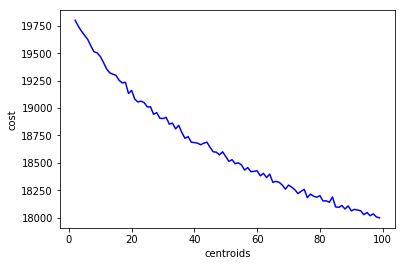

In [7]:
# Plot an elbow curve.
plt.plot(num_centroids, costs, color='blue')
plt.xlabel('centroids')
plt.ylabel('cost')
plt.show()

In [8]:
# Check some silhouette scores.
start_time = datetime.now()
sil_avgs, sil_avgs_centroids = [], []
for i in xrange(95, 100):
    sil_avg = silhouette_score(data, labels[i-2])
    print('centroids: %d, silhouette average: %f' % (kmeans[i-2].n_clusters, sil_avg))
    sil_avgs.append(sil_avg)
    sil_avgs_centroids.append(kmeans[i-2].n_clusters)

print('Elapsed time: {}'.format(datetime.now() - start_time))

centroids: 95, silhouette average: 0.022405
centroids: 96, silhouette average: 0.022595
centroids: 97, silhouette average: 0.021322
centroids: 98, silhouette average: 0.022454
centroids: 99, silhouette average: 0.022056
Elapsed time: 0:01:46.994121


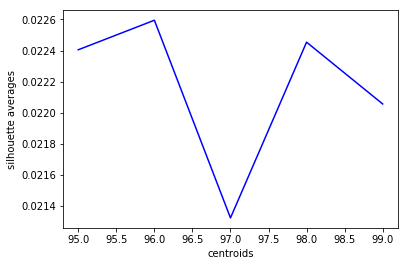

In [9]:
# Plot the silhouette averages
plt.plot(sil_avgs_centroids, sil_avgs, color='blue')
plt.xlabel('centroids')
plt.ylabel('silhouette averages')
plt.show()

In [10]:
# Chosen number of centroids: 96
chosen_model = kmeans[96-2]
chosen_model_labels = labels[96-2]

In [11]:
# Let's check three sample groups, their medoid documents, and two other closer documents.
for i in [24, 48, 72]:
    print('Group: %d' % i)
    center = chosen_model.cluster_centers_[i]
    group_points = data[chosen_model_labels == i]
    group_doc_ids = ids[chosen_model_labels == i]

    # Let's find the medoid and their closest points
    distancesMatrix = pairwise_distances(group_points, metric='euclidean')
    closest_to_medoid_indexes = np.argsort(distancesMatrix.sum(axis=0))
    medoid_index = closest_to_medoid_indexes[0]

    print(' - Medoid doc: {}'.format(group_doc_ids[medoid_index]))
    print(loadDocument(group_doc_ids[medoid_index]))
    print(' - ')
    print(' -- Closest to medoid doc: {}'.format(group_doc_ids[closest_to_medoid_indexes[1]]))
    print(loadDocument(group_doc_ids[closest_to_medoid_indexes[1]]))
    print(' -- ')
    print(' --- Second closest to medoid doc: {}'.format(group_doc_ids[closest_to_medoid_indexes[2]]))
    print(loadDocument(group_doc_ids[closest_to_medoid_indexes[2]]))
    print(' --- ')

Group: 24
 - Medoid doc: 3642a06bfe192d05b0c7314be16d3d8f9a7b9322
Newsgroups: comp.sys.mac.hardwarePath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!s5!is1.is.morgan.com!is0.is.morgan.com!gmichFrom: gmich@is.morgan.com (George Michaels)Subject: NTSC and thMessage-ID: <GMICH.93Apr19145538@idt114.is.morgan.com>Sender: news@is.morgan.comNntp-Posting-Host: idt114Organization: Morgan Stanley & CompanyDistribution: compDate: Mon, 19 Apr 1993 19:55:38 GMTLines: 0
 - 
 -- Closest to medoid doc: 416b7e833bac2c603bdfb5b52dd067ced2778507
Path: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!unisql!wratFrom: wrat@unisql.UUCP (wharfie)Newsgroups: rec.autosSubject: Re: Where can I get a New York taxi?Message-ID: <5277@unisql.UUCP>Date: 20 Apr 93 13:54:14 GMTReferences: <5266@unisql.UUCP> 